In [2]:
#import pomegranate
#pomegranate.utils.enable_gpu()
from IPython.display import HTML, display

from __future__ import print_function
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import datetime
import pandas
import numpy as np
np.set_printoptions(threshold=np.nan)
from matplotlib import cm, pyplot as plt
from pomegranate import *
pandas.options.display.max_rows=500
from random import shuffle
from sklearn.metrics import accuracy_score

In [3]:
def load_data(year="2017", airport=None):
    data=pandas.read_csv("./data/processed/"+year+".csv")
    # define delay as DepDelay > 30 or ArrDelay>30 -- which implies traveler anxious at airport or miss connection flight
    data["Delay"] = ((data["DepDelay"] > 30) | (data["ArrDelay"] > 30))*1

    # discretize ArrTime, DepTime, AirTime,Distance
    # ArrTime, DepTime are divided by 100, because 22:30 is sored as 2230.
    # AirTime is divided into hours
    # Distance is divided by 250
    data = data.sort_values(['Year', 'Month','DayofMonth','CRSDepTime'], ascending=[True, True, True, True])
    data["ArrTime"] = data["ArrTime"]//100
    data["DepTime"] = data["DepTime"]//100
    data["AirTime"] = data["AirTime"]//60
    data["Distance"] = data["Distance"] // 250
    label_set = pandas.factorize(data["UniqueCarrier"])
    data["UniqueCarrier"]=label_set[0]
    # for keep data from certain airport

    if airport:
        data = data.query("Origin==\'"+airport+"\'")
        # data = data[data["Origin"]=="IAH"]
    data = data.drop("Dest",1)
    data = data.drop("Origin",1)
    data = data.drop("Quarter",1)
    display(data.head())
    return data

# utility for model scoring
# the model has two states, 0 or 1. The state 0 and 1 may mean different things for each run, so it may need to be flipped.
def score_model(model, data, truth, flip=False):
    if flip:        
        return accuracy_score(model.predict(data),truth)
    else:
        return 1 - accuracy_score(model.predict(data),truth)
# score the model given validation serires
def score_model_given_series(model, validate_x, validate_y):
    # is 0 delay or is 1 delay
    zero_score = score_model(model, validate_x[0], validate_y[0])
    one_score = score_model(model, validate_x[0], validate_y[0], True)
    flip = None
#     if zero_score > one_score:
#         flip = False
#     else:
#         flip = True
    sum_score = 0
    for i in range(len(validate_x)):
        score = score_model(model, validate_x[i], validate_y[i], flip)
        sum_score += score
    print(sum_score/len(validate_x))

In [4]:
data = load_data("data_all", "ATL")

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,FlightNum,OriginAirportID,DestAirportID,ArrTime,AirTime,Distance,DepDelay,ArrDelay,DepTime,CRSDepTime,Cancelled,Delay
21196400,2013,1,1,2,8,6059,10397,12264,7.0,1.0,2.0,-3.0,-8.0,5.0,545,0.0,0
21204954,2013,1,1,2,12,425,10397,11292,8.0,3.0,4.0,76.0,90.0,7.0,605,0.0,1
21272158,2013,1,1,2,1,429,10397,11298,7.0,1.0,2.0,-6.0,-26.0,5.0,605,0.0,0
21519064,2013,1,1,2,9,4652,10397,12953,10.0,1.0,3.0,137.0,120.0,8.0,610,0.0,1
21199942,2013,1,1,2,8,4114,10397,12266,9.0,2.0,2.0,132.0,138.0,8.0,620,0.0,1


In [10]:
# splice_series to day
def splice_series(input_data, split=0.8):
    # split is the split ratio for train vs validate
    x = []
    y = []
#     "DestAirportID", "AirTime", "CRSDepTime", "Delay"
    features = [ "DestAirportID", "AirTime", "CRSDepTime", "Delay"]
    for year in input_data.Year.unique():
        for month in input_data.Month.unique():
            for day in input_data.DayofMonth.unique():
                hold = input_data[(input_data.Month == month) & (input_data.DayofMonth==day)& (input_data.Year==year)]
                hold = hold.sort_values(axis=0,by="CRSDepTime")[features]
                if len(hold>0):
#                     x.append(hold.loc[:, hold.columns != 'Delay'].as_matrix().astype(int).tolist())
                    x.append(hold.as_matrix().astype(int))
                    y.append(hold.loc[:, hold.columns == 'Delay'].as_matrix().astype(int).flatten())
    x = np.array(x) 
    y = np.array(y)
    indexer = np.random.permutation(x.shape[0])
    x = x[indexer]
    y = y[indexer]
    train_x= x[:int(x.shape[0]*split)]
    train_y = y[:int(x.shape[0]*split)]    
    validate_x = x[int(x.shape[0]*split):]
    validate_y = y[int(x.shape[0]*split):]    
    return train_x, train_y, validate_x, validate_y
#     return validate_x, validate_y, train_x, train_y

In [11]:
train_x, train_y, validate_x, validate_y = splice_series(data)


In [13]:
d1 = DiscreteDistribution({1: 0.9, 0:0.1})
d2 = DiscreteDistribution({1: 0.5, 0:0.5})
s1 = State( d1, name='congested' )
s2 = State( d2, name='non congested' )
model = HiddenMarkovModel()

model.add_states(s1, s2)
model.add_transition( model.start, s1, 0.5 )
model.add_transition( model.start, s2, 0.5 )
model.add_transition( s1, s1, 0.9 )
model.add_transition( s1, s2, 0.1 )
model.add_transition( s2, s1, 0.5 )
model.add_transition( s2, s2, 0.5 )
model.bake()
model.states
# print(train_y[0].shape)

model.fit(train_y)
# score_model_given_series(model, validate_y,  validate_y)
# print(np.mean(data.Delay))

1327207.544556913

In [36]:
validate_x[0]
start = len(validate_x[0])//2
sample = list(validate_x[0][:start])
sample.append(validate_x[0][start])
# print(np.array(sample))
# sample = [[11057,0,   545,     0],
#  [12953,     1,   550,     0],
#  [11292,     2,   600,     0],
#  [13204,     1,   600,     0],
#  [12953,     1,   600,     0],
#  [13232,     1,   605,     0],
#  [10821,     1,   615,     0]]
1
print(model.predict_proba([0,0,0,0,0,0,0,0,0,0,]))
# sample[-1][1]
# print(model.log_probability(sample))


[[ 0.03669061  0.96330939]
 [ 0.04925687  0.95074313]
 [ 0.07346684  0.92653316]
 [ 0.12008726  0.87991274]
 [ 0.2098514   0.7901486 ]
 [ 0.38267961  0.61732039]
 [ 0.71543287  0.28456713]
 [ 0.76704523  0.23295477]
 [ 0.77492216  0.22507784]
 [ 0.77529583  0.22470417]]


In [33]:
model.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "1" : 0.519103157079172,
                 "0" : 0.4808968429208308
             }
         ],
         "frozen" : false
     },
     "name" : "congested",
     "weight" : 1.0
 }, {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "1" : 0.08003540146546236,
                 "0" : 0.919964598534537
             }
         ],
         "frozen" : false
     },
     "name" : "non congested",
     "weight" : 1.0
 }, {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 }, {
     "class" : "State",
     "distribution" : null,
     "name" : "None-end",
     "weight" : 1.0
 }]

In [39]:
print(train_x[:100])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
len(validate_x)+len(train_x)

1734

In [41]:
print(len(data))

1789222


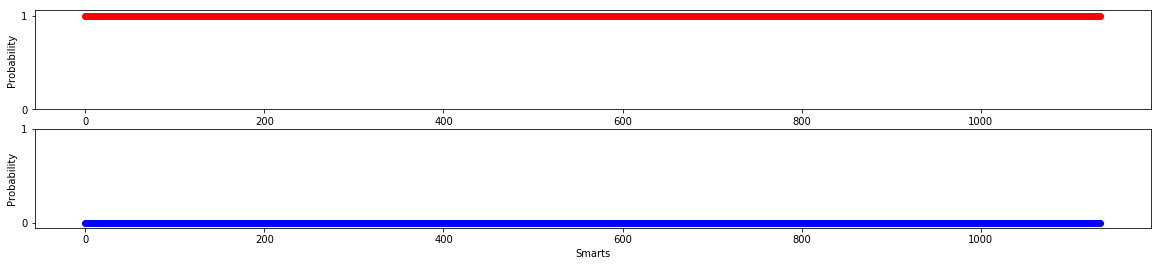

In [127]:
s = validate_x[5][:,-1]

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(211)

ax.plot(p, 'ro')
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.yticks([0,1])
ay = fig.add_subplot(212)
p = pandas.DataFrame(s)
s = 1-np.array(model.predict(validate_x[5][:,-1]))
p = pandas.DataFrame(s)
ay.plot(p,'bo')
plt.yticks([0,1])


plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.show()


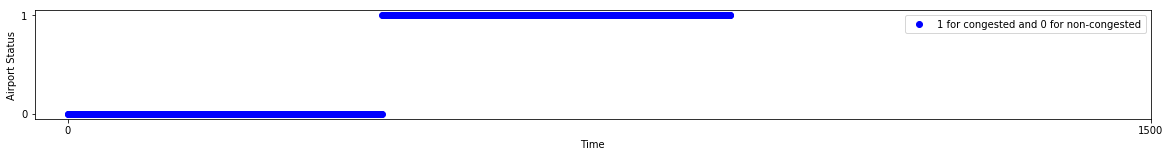

In [146]:
s = 1-np.array(model.predict(validate_x[4][:,-1]))
# s = validate_x[5][:,-1]
p = pandas.DataFrame(s)
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)

ax.plot(p, 'bo', label='sine')
plt.yticks([0, 1])
plt.xticks([0,1500])
plt.xlabel("Time")
plt.ylabel("Airport Status")
L=plt.legend()
L.get_texts()[0].set_text('1 for congested and 0 for non-congested')
plt.show()

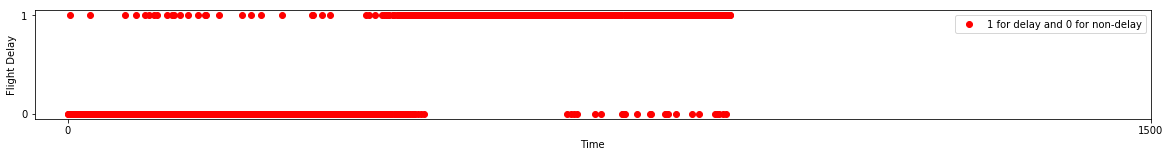

In [145]:
# s = model.predict(validate_x[5][:,-1])
s = validate_x[4][:,-1]
p = pandas.DataFrame(s)
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.plot(p, 'ro', label='sine')
plt.yticks([0, 1])
plt.xticks([0,1500])
plt.xlabel("Time")
plt.ylabel("Flight Delay")
L=plt.legend()
L.get_texts()[0].set_text('1 for delay and 0 for non-delay')
plt.show()

In [152]:
print(np.mean(validate_x[5][:,-1]))

0.0767195767196


In [149]:
len(validate_x[5][:-1])

1133

In [153]:
print(np.mean(validate_x[4][:,-1]))

0.500544069641


In [154]:
len(validate_x[4][:-1])

918

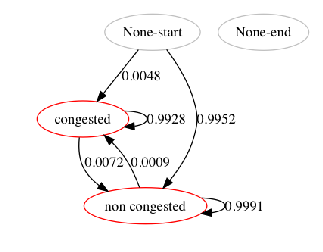

In [156]:
model.plot()
plt.show()

In [157]:
model.to_json()


'{\n    "class" : "HiddenMarkovModel",\n    "name" : "None",\n    "start" : {\n        "class" : "State",\n        "distribution" : null,\n        "name" : "None-start",\n        "weight" : 1.0\n    },\n    "end" : {\n        "class" : "State",\n        "distribution" : null,\n        "name" : "None-end",\n        "weight" : 1.0\n    },\n    "states" : [\n        {\n            "class" : "State",\n            "distribution" : {\n                "class" : "Distribution",\n                "name" : "DiscreteDistribution",\n                "parameters" : [\n                    {\n                        "1" : 0.519103157079172,\n                        "0" : 0.4808968429208308\n                    }\n                ],\n                "frozen" : false\n            },\n            "name" : "congested",\n            "weight" : 1.0\n        },\n        {\n            "class" : "State",\n            "distribution" : {\n                "class" : "Distribution",\n                "name" : "Discr